In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import isfile, join
from os import listdir

from quick_a_b import *

# Imports for regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# First predict mre
X = []
y = []
path = "/home/asoria/Documents/proyecto_bretagne/"
for folder in os.listdir(path):
    hs = join(path, folder)
    print(hs)

    folder_path = join(hs,"original_images/")

    report_before_path = join(hs,"report_original.xml")
    report_after_path = join(hs,"report_blurred.xml")
    print(report_before_path)
    print(report_after_path)
    medians_images, medians_detections, deg_results = q_analyze_blur(hs, folder_path, report_before_path, report_after_path);
    X.append(medians_detections)
    y.append(deg_results['mre'])


path2 = "/home/asoria/Documents/proyecto_cars/"
for folder2 in os.listdir(path2):
    hs2 = join(path2, folder2)
    print(hs2)

    folder_path2 = join(hs2,"original_images/")

    report_before_path2 = join(hs2,"report_original.xml")
    report_after_path2 = join(hs2,"report_blurred.xml")
    print(report_before_path2)
    print(report_after_path2)
    medians_images2, medians_detections2, deg_results2 = q_analyze_blur(hs2, folder_path2, report_before_path2, report_after_path2);
    X.append(medians_detections2)
    y.append(deg_results2['mre'])
print(X,y)

/home/asoria/Documents/proyecto_bretagne/port_st_guenole
/home/asoria/Documents/proyecto_bretagne/port_st_guenole/report_original.xml
/home/asoria/Documents/proyecto_bretagne/port_st_guenole/report_blurred.xml
Initial folder checks
N images  79
Folder exists: True , and there are 79 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  66
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections
DONE report before path
DONE results after path
                before    after  degradation_perc
n_calibrated       799      720          9.887359
optim             0.54     13.7        -24.370370
2D_BBA         2070272  6058849       -192.659564
3D_BBA          760961  2195664       -188.538309
keypoints_img    22292    22204          0.394760
matches_img       2169     7619       -251.267865
mre             0.2055   0.3386     

In [3]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators=len(est.estimators_)
    test_dev = np.empty(n_estimators)
    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(8, 5))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, label='Train %s' % label, linewidth=2, alpha=alpha)

    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    return test_dev, ax


In [4]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

REAL DATA

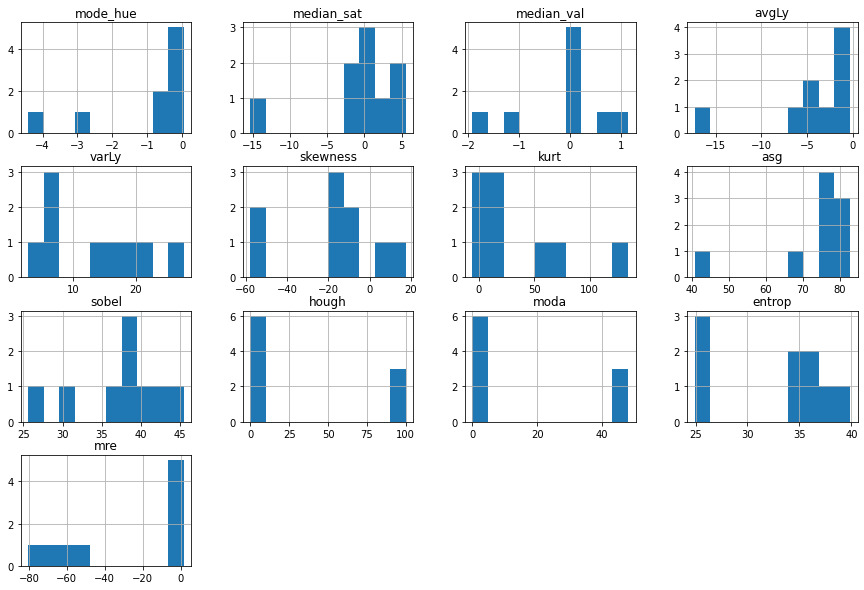

In [5]:
# Analyze the data (missing values, zeros, etc.)

names = ['mode_hue', 'median_sat', 'median_val', 'avgLy', 'varLy', 'skewness', 'kurt', 'asg', 'sobel', 'hough', 'moda', 'entrop']

X_df = pd.DataFrame(data=np.array(X), columns=names)
X_df['mre'] = np.array(y)
f, ax0 = plt.subplots(figsize=(15,10))
X_df.hist(ax = ax0, bins = 10);

In [7]:
# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


{}
{'min_samples_leaf': 3}
{'learning_rate': 0.02}
{'max_depth': 5}
{'max_features': 'sqrt'}
{'subsample': 0.5}


Text(0.5, 1.0, 'Various errors for different parameter setting')

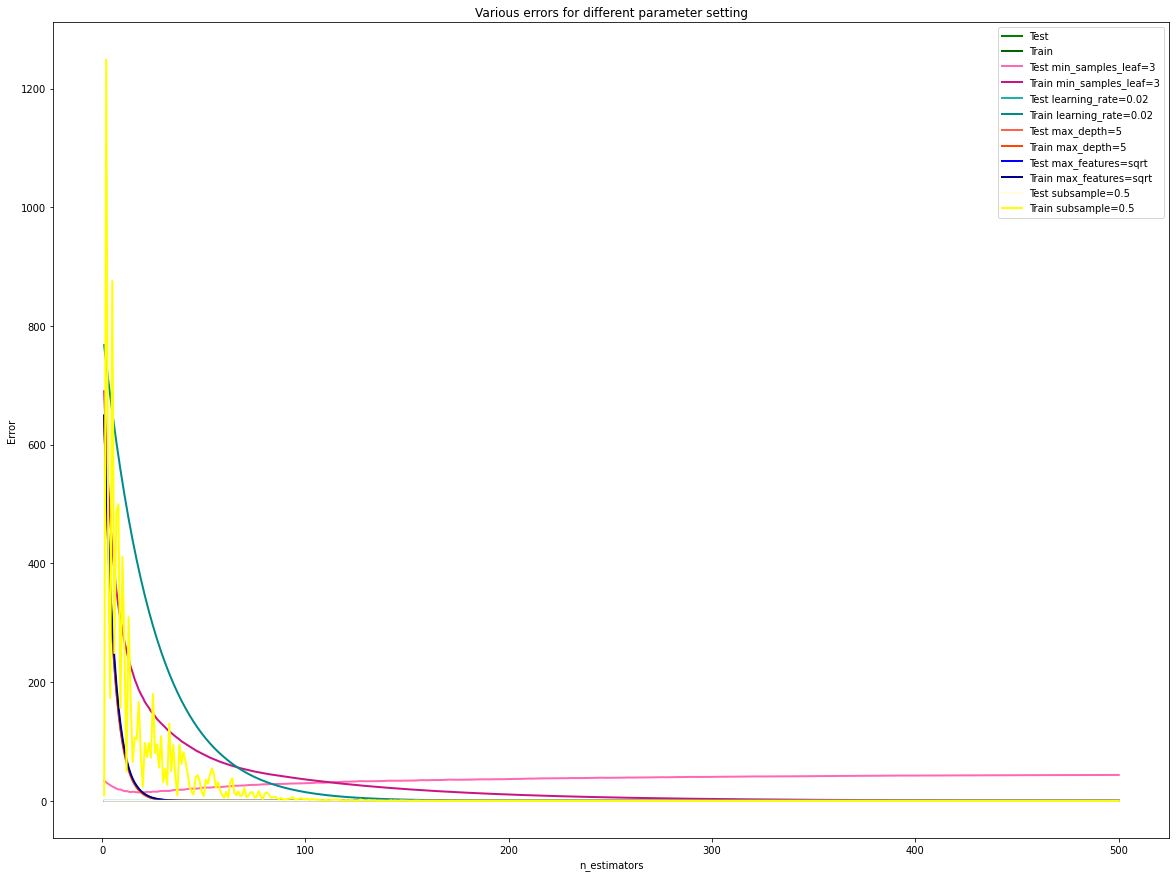

In [8]:
# Some visual first results on parameter dependency

fig = plt.figure(figsize=(20, 15))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#008000', '#006400')),  
 ({'min_samples_leaf': 3},('#ff69b4', '#c71585')), 
 ({'learning_rate': 0.02},('#20b2aa', '#008b8b')),
 ({'max_depth': 5} ,('#ff6347', '#ff4500')) , 
 ({'max_features': 'sqrt' },('#0000ff', '#00008b')) , 
 ({'subsample': 0.5},('#ffffe0', '#ffff00')) ]:



   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting')


In [16]:
# Tune the hyperparameters
#param_grid = {'learning_rate': [0.5, 0.1, 0.05, 0.02],'max_depth': [1, 3, 5, 9],'min_samples_leaf': [1, 3, 10, 17], 'max_features': ['sqrt','log2'], 'subsample': [0.1, 0.5, 0.8]}

param_grid = {'learning_rate': [0.5, 0.1, 0.05],'max_depth': [1, 3, 5],'min_samples_leaf': [1, 3], 'max_features': ['sqrt', 'log2'], 'subsample': [0.5, 0.8, 1]}

est = GradientBoostingRegressor(n_estimators=800)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=1).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

{'learning_rate': 0.5,
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'subsample': 0.5}

In [17]:
# Create the estimator with good parameters

estimator = GradientBoostingRegressor(n_estimators = 800, learning_rate = 0.5, max_depth = 1, max_features = 'sqrt', min_samples_leaf = 1, subsample = 0.5)
estimator.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, max_features='sqrt',
                          n_estimators=800, subsample=0.5)

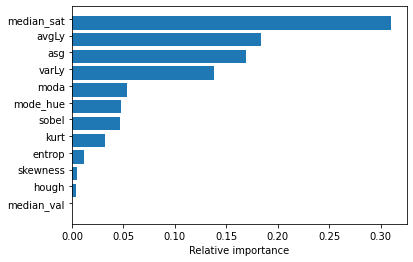

In [18]:
# sort importances
indices = np.argsort(estimator.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), estimator.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

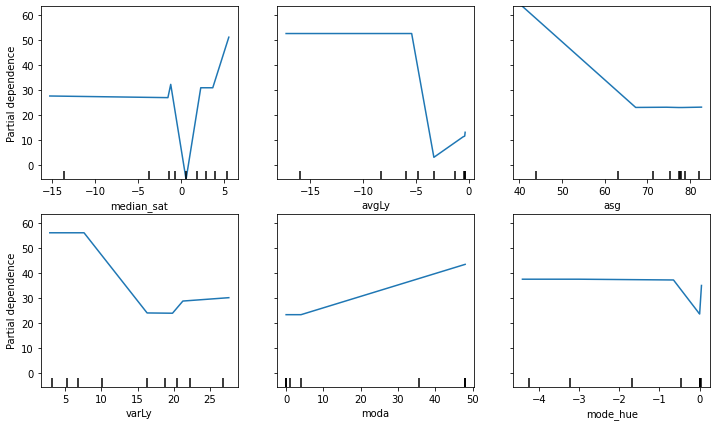

In [22]:
# See the partial dependency of "y" on one feature
#names = ['mode_hue', 'median_sat', 'median_val', 'avgLy', 'varLy', 'skewness', 'kurt', 'asg', 'sobel', 'hough', 'moda', 'entrop']

features = ['median_sat', 'avgLy', 'asg', 'varLy','moda', 'mode_hue']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

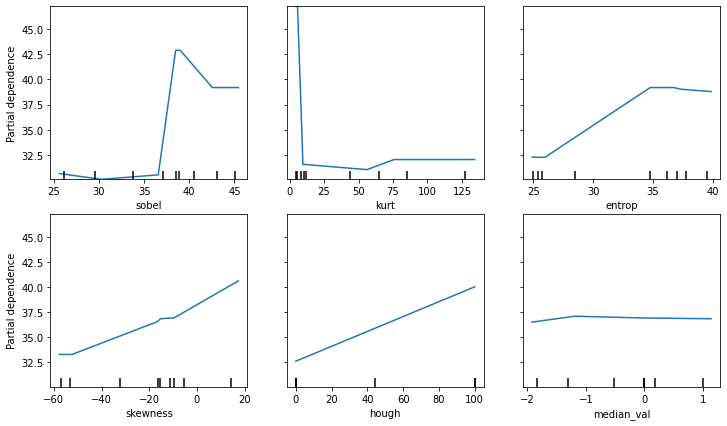

In [23]:

features = ['sobel', 'kurt', 'entrop', 'skewness','hough', 'median_val']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

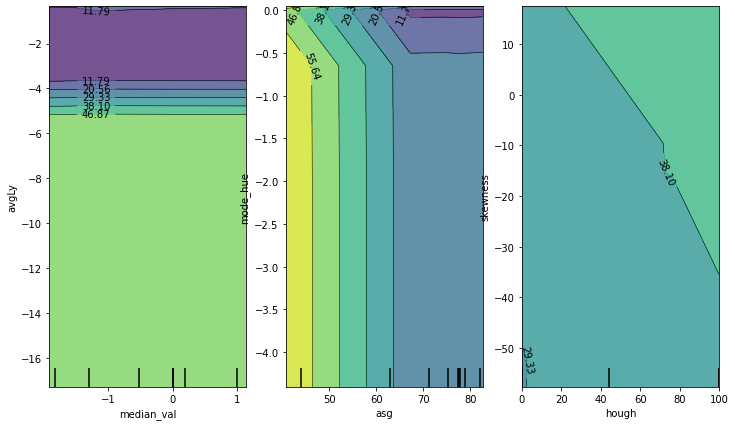

In [25]:
# See the partial dependency of "y" on two features
features2 = [('median_val', 'avgLy'), ('asg', 'mode_hue'),('hough', 'skewness')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features2, feature_names=names, ax=ax);

In [26]:
print("Model Accuracy: %.3f" % estimator.score(X_test, y_test))

Model Accuracy: -2.630


In [27]:
# Calculate the MAE
mae = mean_absolute_error(y_test, estimator.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 51.5353


FAKE DATA

In [ ]:
# Extract the data
cal_housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(cal_housing.data, np.log(cal_housing.target), test_size=0.2, random_state=1)
names = cal_housing.feature_names

In [ ]:
# Check some data
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
f, ax0 = plt.subplots(figsize=(15,8))
X_df.hist(bins=14, ax=ax0);

In [ ]:
# Some visual first results on parameter dependency

fig = plt.figure(figsize=(20, 15))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#008000', '#006400')),  
 ({'min_samples_leaf': 3},('#ff69b4', '#c71585')), 
 ({'learning_rate': 0.02},('#20b2aa', '#008b8b')),
 ({'max_depth': 5} ,('#ff6347', '#ff4500')) , 
 ({'max_features': 'sqrt' },('#0000ff', '#00008b')) , 
 ({'subsample': 0.5},('#ffffe0', '#ffff00')) ]:



   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting')



In [ ]:
# Tune the hyperparameters
param_grid = {'learning_rate': [0.5, 0.1, 0.05, 0.02],'max_depth': [1, 3, 5, 9],'min_samples_leaf': [1, 3, 10, 17], 'max_features': ['sqrt','log2'], 'subsample': [0.1, 0.5, 0.8]}


est = GradientBoostingRegressor(n_estimators=800)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=2).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

In [ ]:
# Create the estimator with good parameters

estimator = GradientBoostingRegressor(n_estimators = 800, learning_rate = 0.02, max_depth = 9, max_features = 'log2', min_samples_leaf = 3, subsample = 0.8)
estimator.fit(X_train, y_train)

In [ ]:
# sort importances
indices = np.argsort(estimator.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), estimator.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

In [ ]:
# See the partial dependency of "y" on one feature
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

In [ ]:
# See the partial dependency of "y" on two features
features2 = [('MedInc', 'AveOccup'), ('HouseAge', 'AveRooms'),('AveOccup', 'HouseAge')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features2, feature_names=names, ax=ax);

In [ ]:
print("Model Accuracy: %.3f" % estimator.score(X_test, y_test))

In [ ]:
# Calculate the MAE
mae = mean_absolute_error(y_test, estimator.predict(X_test))
print('MAE: %.4f' % mae)